## Using ODE/SDE-based models to solve inverse problems
### Melnik Yury
github: https://github.com/yur1xfd </br>
tg: @yur1xfd

In [1]:
import os
import math
import warnings
from typing import Dict, List, Optional, Tuple, Union

import glob
import regex

import tqdm.notebook as tqdm

import numpy as np
import numpy.testing as npt

import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib_inline
import matplotlib.pyplot as plt

from IPython.display import display, Audio, Markdown

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 972.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 5.9 MB/s eta 0:00:00


## 1. Gaussian Noise -> MNIST

In [3]:
import torchvision.transforms as transforms
import torchvision
from tqdm import tqdm

In [71]:
from torchvision.datasets import MNIST

In [72]:
mnist_ds = MNIST(root='/content', download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 123687539.96it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 101880314.40it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46682628.72it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2291930.79it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [73]:
mnist_train = MNIST(root='/content', train=True, transform=transforms.Compose([
transforms.ToTensor(), transforms.Resize(size=(32, 32))]))

In [74]:
g = torch.Generator().manual_seed(2718281828)
np.random.seed(14)
# train_data = torch.utils.data.random_split(mnist_train, [0.5, 0.5], generator=g)[0]
train_data_loader = DataLoader(mnist_train, batch_size=128, num_workers=0, shuffle=True, generator=g)

In [4]:
import fp16_util
import nn
import unet

In [5]:
from unet import UNetModel

In [75]:
model = UNetModel(in_channels=1, model_channels=64, out_channels=1,
num_res_blocks=3, attention_resolutions=("16",))

In [ ]:
count = 0
for param in model.parameters():
    count += (param.view(-1, 1).shape[0])

In [ ]:
count

73443649

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_epoch = 15
# step_size = 5
optimizer = torch.optim.Adam(model.parameters())
device = torch.device("cuda:0")

In [78]:
# ODE train loop
def train(model):
    model = model.to(device)
    train_loss= list()
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in tqdm(train_data_loader):
            optimizer.zero_grad()
            x1 = inputs.to(device)
            x0 = torch.tensor(np.random.normal(size=(x1.shape[0], 1, 32, 32)), dtype=torch.float32).to(device)
            t = torch.tensor(np.random.uniform(size=(x1.shape[0], 1, 1, 1)), dtype=torch.float32).to(device)
            x_t = t * x1 + (1 - t) * x0

            outputs = model(x_t, t.squeeze())
            loss = ((outputs -(x1 - x0)) ** 2).mean()
            loss.backward()
            optimizer.step()

        # scheduler.step()
        print('Train loss: ', loss.item())
        if epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/ode_model2.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ode_optim2.pth')

        train_loss.append(loss.item())
        output = eval(model)
        plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
        plt.show()

    return train_loss

In [77]:
# ODE inference
@torch.no_grad()
def eval(model, x0, num_steps=100):
    model.eval()
    x0 = torch.tensor(np.random.normal(size=(16, 1, 32, 32)), dtype=torch.float32).to(device)
    t = torch.zeros(16, ).to(device)
    for i in range(1, num_steps + 1):
        x_t = x0 + (1 / num_steps) * model(x0, t)
        x0 = x_t
        t += (1 / num_steps)

    return x_t

In [76]:
# SDE train loop
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

def train_brown(model, eps=1e-2):
    model = model.to(device)
    train_loss= list()
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in tqdm(train_data_loader):
            optimizer.zero_grad()
            x1 = inputs.to(device)
            x0 = Normal(torch.zeros_like(x1), torch.ones_like(x1)).sample().to(device)
            t = Uniform(low=1e-4, high=(1 - 1e-4)).sample((x1.shape[0], 1, 1, 1)).to(device)
            # t = torch.rand(size=(x1.shape[0], 1, 1, 1), dtype=torch.float32).to(device)
            x_t = Normal(loc=(t * x1 + (1 - t) * x0), scale=(eps * t * (1 - t) * torch.ones_like(x1))).sample()

            outputs = model(x_t, t.squeeze())
            loss = ((outputs - (x1 - x_t) / (1 - t)) ** 2).mean()
            loss.backward()
            optimizer.step()

        # scheduler.step()
        print('Train loss: ', loss.item())
        if epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/brown_model.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/brown_optim2.pth')

        train_loss.append(loss.item())
        output = eval_brown(model, eps=eps)
        print('----------------Nan Check---------------')
        for param in model.parameters():
            print(torch.isnan(param.grad).sum())
        plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
        plt.show()

    torch.save(model.state_dict(), '/content/drive/MyDrive/brown_model.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/brown_optim.pth')

    return train_loss

In [79]:
# SDE inference
@torch.no_grad()
def eval_brown(model, x0, num_steps=100, eps=1e-2):
    model.eval()
    # x0 = Normal(torch.zeros(16, 1, 32, 32), torch.ones(16, 1, 32, 32)).sample().to(device)
    t = torch.zeros(16, ).to(device)
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(torch.tensor((eps / num_steps), dtype=torch.float32, device=device)) * z_t
          x0 = x_t
          t += (1 / num_steps)

    return x_t

In [ ]:
train_loss = train_brown(model)

In [80]:
basic_model = UNetModel(in_channels=1, model_channels=64, out_channels=1,
num_res_blocks=3, attention_resolutions=("16",))

In [81]:
# ODE for generation from noise
basic_model.load_state_dict(torch.load('/content/drive/MyDrive/ode_model.pth'))

<All keys matched successfully>

In [82]:
# ODE for generation from noise
model.load_state_dict(torch.load('/content/drive/MyDrive/brown_model.pth'))

<All keys matched successfully>

In [106]:
# comparison of ODE & SDE
def compare_model(model1, model2):
  x0 = Normal(torch.zeros(16, 1, 32, 32), torch.ones(16, 1, 32, 32)).sample().to(device)
  output1 = eval(model1, x0)
  output2 = eval_brown(model2, x0)
  plt.imshow(torchvision.utils.make_grid(output1).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
  plt.show()
  plt.imshow(torchvision.utils.make_grid(output2).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
  plt.show()


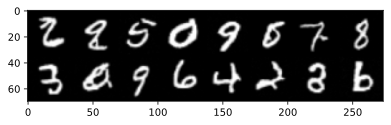

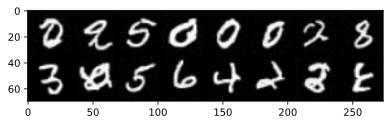

In [107]:
basic_model = basic_model.to(device)
model = model.to(device)
compare_model(basic_model, model)

In [92]:
# ODE gradual generation from noise
@torch.no_grad()
def ode_gen(model, num_steps=100):
    model.eval()
    x0 = torch.tensor(np.random.normal(size=(1, 1, 32, 32)), dtype=torch.float32).to(device)
    sequence_blur = x0.clone().detach()
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        x_t = x0 + (1 / num_steps) * model(x0, t)
        x0 = x_t
        t += (1 / num_steps)
        if i % 25 == 0:
          sequence_blur = torch.cat((sequence_blur, x_t))

    return sequence_blur

In [108]:
# SDE gradual generation from noise
@torch.no_grad()
def sde_gen(model, num_steps=100, eps=1e-2):
    model.eval()
    x0 = Normal(torch.zeros(1, 1, 32, 32), torch.ones(1, 1, 32, 32)).sample().to(device)
    t = torch.zeros(1, ).to(device)
    sequence_blur = x0.clone().detach()
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
          sequence_blur = torch.cat((sequence_blur, x_t))
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(torch.tensor((eps / num_steps), dtype=torch.float32, device=device)) * z_t
          x0 = x_t
          t += (1 / num_steps)
          if i % 25 == 0:
            sequence_blur = torch.cat((sequence_blur, x_t))

    return sequence_blur

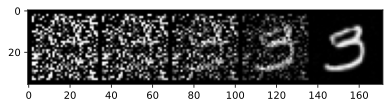

In [100]:
output = ode_gen(basic_model)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

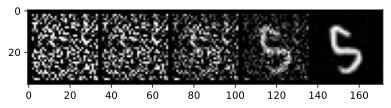

In [112]:
output = sde_gen(model, eps=1e-2)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

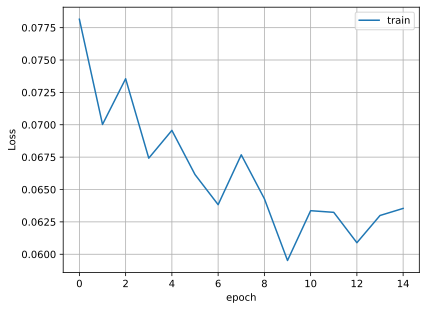

In [ ]:
plt.plot(train_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
train_loss = train(model)

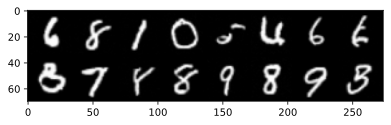

In [ ]:
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')

In [ ]:
import gc

In [ ]:
torch.cuda.empty_cache()
gc.collect()

7885

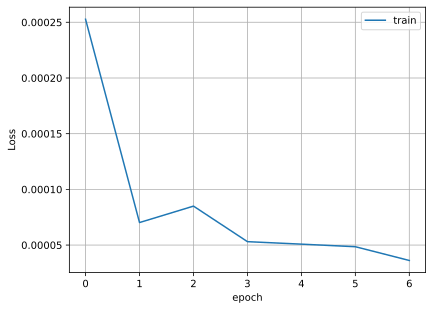

In [ ]:
plt.plot(train_loss, label='train')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
# plt.xscale('log')
plt.savefig('/content/drive/MyDrive/ode_exp.pdf')
plt.show()

## 2. DeBluring

### MNIST Dataset

In [ ]:
mnist_train = MNIST(root='/content', train=True, transform=transforms.Compose([
transforms.ToTensor(), transforms.Resize(size=(32, 32))]))

In [ ]:
transforms.GaussianBlur(7, sigma=(5, 10))

GaussianBlur(kernel_size=(7, 7), sigma=(5, 10))

In [ ]:
g1 = torch.Generator().manual_seed(2718281828)
g2 = torch.Generator().manual_seed(2713481628)
np.random.seed(14)
train_data, test_data = torch.utils.data.random_split(mnist_train, [0.9, 0.1], generator=g2)
train_data_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=True, generator=g1)
test_data_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)

In [ ]:
import fp16_util
import nn
import unet

In [ ]:
from unet import UNetModel

In [46]:
model = UNetModel(in_channels=1, model_channels=64, out_channels=1,
num_res_blocks=3, attention_resolutions=("16",))

In [48]:
model.load_state_dict(torch.load('/content/drive/MyDrive/ode_fashion_model20.pth'))

<All keys matched successfully>

In [49]:
num_epoch = 10
# step_size = 5
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
device = torch.device("cuda:0")

In [50]:
optimizer.load_state_dict(torch.load('/content/drive/MyDrive/ode_fashion_optim20.pth'))

In [45]:
# for using optimizer in additional trainig
def optimizer_to(optim, device):
    for param in optim.state.values():
        # Not sure there are any global tensors in the state dict
        if isinstance(param, torch.Tensor):
            param.data = param.data.to(device)
            if param._grad is not None:
                param._grad.data = param._grad.data.to(device)
        elif isinstance(param, dict):
            for subparam in param.values():
                if isinstance(subparam, torch.Tensor):
                    subparam.data = subparam.data.to(device)
                    if subparam._grad is not None:
                        subparam._grad.data = subparam._grad.data.to(device)

In [51]:
optimizer_to(optimizer, device)

#### ODE

In [11]:
#ODE deblurinng train
def train_ode(model):
    model = model.to(device)
    train_loss= list()
    blur = transforms.GaussianBlur(7, sigma=(5, 10))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in tqdm(train_data_loader):
            optimizer.zero_grad()
            x1 = inputs.to(device)
            x0 = blur(inputs).to(device)
            t = torch.tensor(np.random.uniform(size=(x1.shape[0], 1, 1, 1)), dtype=torch.float32).to(device)
            x_t = t * x1 + (1 - t) * x0

            outputs = model(x_t, t.squeeze())
            loss = ((outputs -(x1 - x0)) ** 2).mean()
            loss.backward()
            optimizer.step()

        # scheduler.step()
        print('Train loss: ', loss.item())
        if epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/ode_fashion_model20.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ode_fashion_optim20.pth')

        train_loss.append(loss.item())
        output = eval_ode(model, blur)
        plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
        plt.show()

    torch.save(model.state_dict(), '/content/drive/MyDrive/ode_fashion_model20.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/ode_fashion_optim20.pth')

    return train_loss

In [12]:
#ODE debluring inference
@torch.no_grad()
def eval_ode(model, blur, num_steps=100):
    model.eval()
    data, labels = next(iter(test_data_loader))
    x0 = blur(data).to(device)
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        x_t = x0 + (1 / num_steps) * model(x0, t)
        x0 = x_t
        t += (1 / num_steps)

    return x_t[:4]

In [ ]:
train_loss = train_ode(model)

In [13]:
@torch.no_grad()
def ode_compare(model, blur, num_steps=100):
    model.eval()
    data, labels = next(iter(test_data_loader))
    inx = torch.randint(0, 127, (1, ))
    x0 = blur(data[inx]).to(device)
    sequence_blur = data[inx].to(device)
    sequence_blur = torch.cat((sequence_blur, x0))
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        x_t = x0 + (1 / num_steps) * model(x0, t)
        x0 = x_t
        t += (1 / num_steps)
        if i % 25 == 0:
          sequence_blur = torch.cat((sequence_blur, x_t))

    return sequence_blur

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


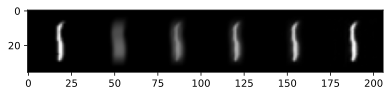

In [ ]:
output = ode_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


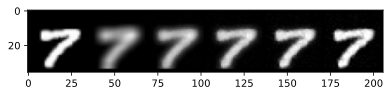

In [ ]:
output = blur_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

#### SDE

In [47]:
model = model.to(device)

In [48]:
model = UNetModel(in_channels=1, model_channels=64, out_channels=1,
num_res_blocks=3, attention_resolutions=("16",))

In [14]:
# SDE debluring train
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

def train_blur(model, eps=5e-5):
    model = model.to(device)
    train_loss= list()
    blur = transforms.GaussianBlur(7, sigma=(5, 10))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in tqdm(train_data_loader):
            optimizer.zero_grad()
            x1 = inputs.to(device)
            x0 = blur(inputs).to(device)
            t = Uniform(low=1e-4, high=(1 - 1e-4)).sample((x1.shape[0], 1, 1, 1)).to(device)
            x_t = Normal(loc=(t * x1 + (1 - t) * x0), scale=(eps * t * (1 - t) * torch.ones_like(x1))).sample()

            outputs = model(x_t, t.squeeze())
            loss = ((outputs - (x1 - x_t) / (1 - t)) ** 2).mean()
            loss.backward()
            optimizer.step()

        print('Train loss: ', loss.item())
        if epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/brown_fashion_model2.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/brown_fashion_optim2.pth')

        train_loss.append(loss.item())
        output = eval_blur(model, blur=blur, eps=eps)
        plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
        plt.show()

    torch.save(model.state_dict(), '/content/drive/MyDrive/brown_fashion_model2.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/brown_fashion_optim2.pth')

    return train_loss

In [15]:
#SDE debluring inference
@torch.no_grad()
def eval_blur(model, blur, num_steps=100, eps=5e-5):
    model.eval()
    data, labels = next(iter(test_data_loader))
    x0 = blur(data).to(device)
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(torch.tensor((eps / num_steps), dtype=torch.float32, device=device)) * z_t
          x0 = x_t
          t += (1 / num_steps)

    return x_t[:4]

In [30]:
@torch.no_grad()
def blur_compare(model, blur, num_steps=100, eps=1e-4):
    model.eval()
    data, labels = next(iter(train_data_loader))
    inx = torch.randint(0, 128, (1, ))
    x0 = blur(data[inx]).to(device)
    sequence_blur = data[inx].to(device)
    sequence_blur = torch.cat((sequence_blur, x0))
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(torch.tensor((eps / num_steps), dtype=torch.float32, device=device)) * z_t
          x0 = x_t
          t += (1 / num_steps)
          if i % (num_steps / 4) == 0:
            sequence_blur = torch.cat((sequence_blur, x_t))

    sequence_blur = torch.cat((sequence_blur, x_t))

    return sequence_blur

In [ ]:
train_loss = train_blur(model)

### FashionMNIST Dataset

In [7]:
from torchvision.datasets import FashionMNIST

In [8]:
fashin_ds = FashionMNIST(root='/content', download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 17088541.64it/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299976.45it/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5590536.81it/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12517262.02it/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [9]:
fashion_train = FashionMNIST(root='/content', train=True, transform=transforms.Compose([
transforms.ToTensor(), transforms.Resize(size=(32, 32))]))

In [10]:
g1 = torch.Generator().manual_seed(2718281828)
g2 = torch.Generator().manual_seed(2713481628)
np.random.seed(14)
train_data, test_data = torch.utils.data.random_split(fashion_train, [0.9, 0.1], generator=g2)
train_data_loader = DataLoader(train_data, batch_size=128, num_workers=0, shuffle=True, generator=g1)
test_data_loader = DataLoader(test_data, batch_size=128, num_workers=0, shuffle=False)

In [134]:
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


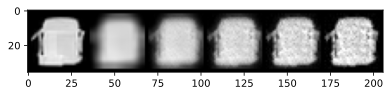

In [132]:
# SDE debluring with beta = 1e-4
output = blur_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


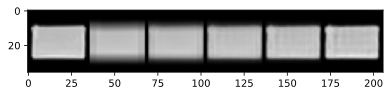

In [68]:
# # SDE debluring with beta = 1e-4 and ODE inference
output = ode_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


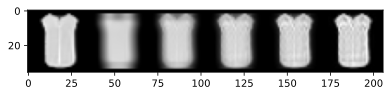

In [150]:
# ODE debluring
output = ode_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


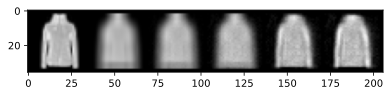

In [ ]:
# SDE debluring with noise scheduler
output = sde_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), beta=triangle_func)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


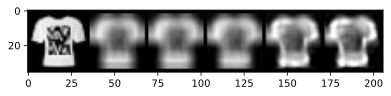

In [63]:
# SDE debluring with noise scheduler
output = ode_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)))
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

#### SDE with noise scheduler

In [17]:
from diffusion import Diffusion
from diffusion import triangle_func

In [22]:
model = UNetModel(in_channels=1, model_channels=64, out_channels=1,
num_res_blocks=3, attention_resolutions=("16",))

In [33]:
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


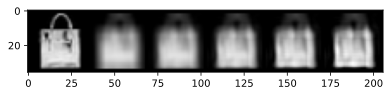

In [ ]:
output = ode_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), num_steps=100)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


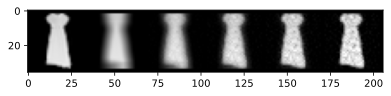

In [31]:
output = blur_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), num_steps=100)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


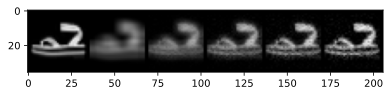

In [ ]:
output = blur_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), num_steps=100)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


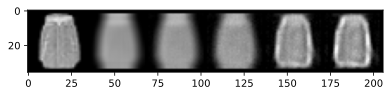

In [36]:
output = sde_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), beta=triangle_func)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

In [76]:
num_epoch = 10
# step_size = 5
optimizer = torch.optim.Adam(model.parameters())
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
device = torch.device("cuda:0")

In [ ]:
diffusion = Diffusion("triangle")
blur = transforms.GaussianBlur(7, sigma=(5, 10))
input = next(iter(train_data_loader))[0]
loss = diffusion(model, x0=input, x1=blur(input))
print(loss)

In [18]:
# SDE debluring train with noise scheduler
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform

def train_sde(model, diff=Diffusion("triangle", beta_min=1e-8, beta_max=1e-5)):
    model = model.to(device)
    train_loss= list()
    blur = transforms.GaussianBlur(7, sigma=(5, 10))
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in tqdm(train_data_loader):
            optimizer.zero_grad()
            x1 = inputs.to(device)
            x0 = blur(inputs).to(device)

            loss = diff(model, x0, x1)
            loss.backward()
            optimizer.step()

        print('Train loss: ', loss.item())
        if epoch > 0 and epoch % 5 == 0:
            torch.save(model.state_dict(), '/content/drive/MyDrive/sde_fashion_model_1e_5.pth')
            torch.save(optimizer.state_dict(), '/content/drive/MyDrive/sde_fashion_optim_1e_5.pth')

        train_loss.append(loss.item())
        output = eval_sde(model, blur=blur, beta=triangle_func)
        plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
        plt.show()

    torch.save(model.state_dict(), '/content/drive/MyDrive/sde_fashion_model_1e_5.pth')
    torch.save(optimizer.state_dict(), '/content/drive/MyDrive/sde_fashion_optim_1e_5.pth')

    return train_loss

In [19]:
#SDE debluring inference with noise scheduler
@torch.no_grad()
def eval_sde(model, blur, beta, num_steps=100):
    model.eval()
    data, labels = next(iter(test_data_loader))
    x0 = blur(data).to(device)
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(beta(t, a=1e-8, b=1e-5) / num_steps).view(x0.shape[0], 1, 1, 1) * z_t
          x0 = x_t
          t += (1 / num_steps)

    return x_t[:4]

In [35]:
@torch.no_grad()
def sde_compare(model, blur, beta, num_steps=100):
    model.eval()
    data, labels = next(iter(test_data_loader))
    inx = torch.randint(0, 128, (1, ))
    x0 = blur(data[inx]).to(device)
    sequence_blur = data[inx].to(device)
    sequence_blur = torch.cat((sequence_blur, x0))
    t = torch.zeros(x0.shape[0], ).to(device)
    for i in range(1, num_steps + 1):
        if i == num_steps:
          x_t = x0 + (1 / num_steps) * model(x0, t)
        else:
          z_t = Normal(torch.zeros_like(x0), torch.ones_like(x0)).sample().to(device)
          x_t = x0 + (1 / num_steps) * model(x0, t) + torch.sqrt(beta(t, a=1e-8, b=1e-3) / num_steps).view(x0.shape[0], 1, 1, 1) * z_t
          x0 = x_t
          t += (1 / num_steps)
          if i % 25 == 0:
            sequence_blur = torch.cat((sequence_blur, x_t))

    sequence_blur = torch.cat((sequence_blur, x_t))

    return sequence_blur

In [ ]:
train_loss = train_sde(model)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


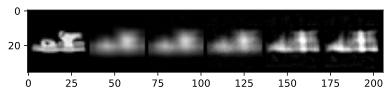

In [ ]:
output = sde_compare(model, blur=transforms.GaussianBlur(7, sigma=(5, 10)), beta=triangle_func)
plt.imshow(torchvision.utils.make_grid(output).permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
plt.show()

#### Pre-trained models

In [ ]:
# ODE FashionMNIST
model.load_state_dict(torch.load('/content/drive/MyDrive/ode_fashion_model20.pth'))

<All keys matched successfully>

In [ ]:
# SDE FashionMNIST
model.load_state_dict(torch.load('/content/drive/MyDrive/brown_fashion_model1.pth'))

<All keys matched successfully>

In [ ]:
# SDE FashionMNIST with scheduler
model.load_state_dict(torch.load('/content/drive/MyDrive/sde_fashion_model_1e_5.pth'))

<All keys matched successfully>